## 0. Importação das bibliotecas

In [47]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Carregando os dados

In [23]:
df_prices = pd.read_csv('../data/raw/teste_indicium_precificacao.csv')
df_prices.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## 2. Descrição dos dados

In [24]:
## Visualizando as colunas do dataset
df_prices.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

## 2.1. Dimensão dos dados

In [12]:
## Verificando o nº de linhas e colunas
print('Número de linhas:{}'.format(df_prices.shape[0]))
print('Número de colunas:{}'.format(df_prices.shape[1]))

Número de linhas:48894
Número de colunas:16


## 2.2. Tipo de dados

In [13]:

## Verificando os tipos de dados, e, se necessário, mudar os tipos não adequados
df_prices.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

## 2.3. Checando valores nulos

In [14]:
## Verificando e Tratando os valores nulos
df_prices.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [ ]:
## O tratamento adequado para os dados NA 
## Para colunas nome e host_name, os valores nulos serão preenchidos por 'Desconhecido'; para valores de ultima_review serão 
# substituídos por uma data padrão e as reviews em branco serão substituídas por 0 

df_prices = df_prices.assign(
    nome=df_prices['nome'].fillna('Desconhecido'),
    host_name=df_prices['host_name'].fillna('Desconhecido'),
    ultima_review=df_prices['ultima_review'].fillna(pd.Timestamp('2000-01-01')),
    reviews_por_mes=df_prices['reviews_por_mes'].fillna(0)
)

## Verificando se ainda há valores nulos 
print(df_prices.isna().sum())



id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64


## Estatística Descritiva

In [20]:
num_attributes = df_prices.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_prices.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## Atributos Numéricos

In [45]:
## Tendências centrais

media = pd.DataFrame(num_attributes.apply(np.mean)).T

mediana = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersão

dispersion1 = pd.DataFrame(num_attributes.apply(np.std)).T  # Desvio padrão
dispersion2 = pd.DataFrame(num_attributes.apply(min)).T  # Valor mínimo
dispersion3 = pd.DataFrame(num_attributes.apply(max)).T  # Valor máximo
dispersion4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T  
dispersion5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


summary_stats = pd.concat([dispersion2, dispersion3, dispersion4, media, mediana, dispersion1, dispersion5, dispersion6]).T.reset_index()
summary_stats.columns = ['Atributos','Valor Mínimo','Valor Máximo', 'Amplitude', 'Media','Mediana','Desvio Padrão','Assimetria','Curtose']
summary_stats = summary_stats.applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)


summary_stats

/tmp/ipykernel_4587/87578903.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_stats = summary_stats.applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)


,Atributos,Valor Mínimo,Valor Máximo,Amplitude,Media,Mediana,Desvio Padrão,Assimetria,Curtose
0,id,"2,595.00","36,487,245.00","36,484,650.00","19,017,532.13","19,677,431.50","10,982,771.74",-0.09,-1.23
1,host_id,"2,438.00","274,321,313.00","274,318,875.00","67,621,393.58","30,795,529.00","78,610,372.25",1.21,0.17
2,latitude,40.50,40.91,0.41,40.73,40.72,0.05,0.24,0.15
3,longitude,-74.24,-73.71,0.53,-73.95,-73.96,0.05,1.28,5.02
4,price,0.00,"10,000.00","10,000.00",152.72,106.00,240.15,19.12,585.66
5,minimo_noites,1.00,"1,250.00","1,249.00",7.03,3.00,20.51,21.83,854.06
6,numero_de_reviews,0.00,629.00,629.00,23.27,5.00,44.55,3.69,19.53
7,reviews_por_mes,0.01,58.50,58.49,1.37,nan,1.68,3.13,42.49
8,calculado_host_listings_count,1.00,327.00,326.00,7.14,1.00,32.95,7.93,67.55
9,disponibilidade_365,0.00,365.00,365.00,112.78,45.00,131.62,0.76,-1.00


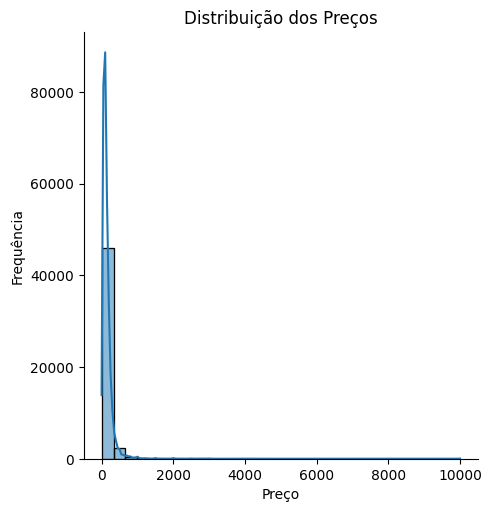

In [56]:
sns.displot(df_prices['price'], bins=30, kde=True)
plt.title('Distribuição dos Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')


plt.show()